In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
from torch.utils.data import random_split

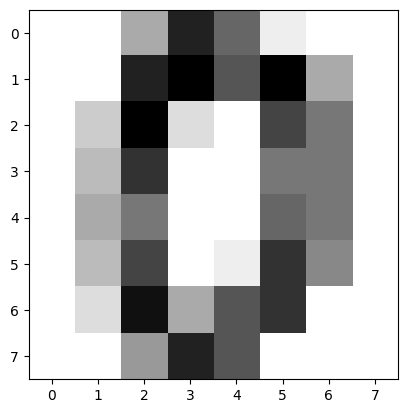

In [9]:
#데이터 확인
digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

In [17]:
# 2. 데이터 분할
# 2-1. (학습+검증) 세트와 테스트 세트로 분할 (예: 80% / 20%)
# stratify=y_full: 클래스 비율을 유지하면서 분할 (분류 문제에서 중요)
X_temp, X_test, y_temp, y_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=42, stratify=digits.target
)
print(f"\n1차 분할 후:")
print(f" (학습+검증) 세트: X_temp={X_temp.shape}, y_temp={y_temp.shape}")
print(f" 테스트 세트: X_test_np={X_test.shape}, y_test_np={y_test.shape}")


1차 분할 후:
 (학습+검증) 세트: X_temp=(1437, 64), y_temp=(1437,)
 테스트 세트: X_test_np=(360, 64), y_test_np=(360,)


In [19]:
# 2-2. (학습+검증) 세트를 다시 학습 세트와 검증 세트로 분할 (예: 75% / 25% -> 전체의 60% / 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp # 0.25 of 0.8 is 0.2 of total
)
print(f"\n2차 분할 후:")
print(f" 학습 세트: X_train_np={X_train.shape}, y_train_np={y_train.shape}")
print(f" 검증 세트: X_val_np={X_val.shape}, y_val_np={y_val.shape}")
print(f" 테스트 세트: X_test_np={X_test.shape}, y_test_np={y_test.shape}")


2차 분할 후:
 학습 세트: X_train_np=(1077, 64), y_train_np=(1077,)
 검증 세트: X_val_np=(360, 64), y_val_np=(360,)
 테스트 세트: X_test_np=(360, 64), y_test_np=(360,)


In [21]:
# 3. NumPy 배열을 PyTorch 텐서로 변환
# 입력 데이터는 float 타입으로, 레이블은 long 타입(분류용)으로 변환합니다.
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print("\nPyTorch 텐서로 변환 후 샘플 형태:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


PyTorch 텐서로 변환 후 샘플 형태:
X_train: torch.Size([1077, 64]), y_train: torch.Size([1077])
X_val: torch.Size([360, 64]), y_val: torch.Size([360])
X_test: torch.Size([360, 64]), y_test: torch.Size([360])


In [22]:
# 4. TensorDataset 생성
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

print(f"\n데이터셋 크기:")
print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")
print(f"테스트 데이터셋 크기: {len(test_dataset)}")


데이터셋 크기:
학습 데이터셋 크기: 1077
검증 데이터셋 크기: 360
테스트 데이터셋 크기: 360


In [29]:
# 5. DataLoader 생성
batch_size = 64 # 배치 크기 설정

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # 검증 시에는 섞지 않음
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # 테스트 시에도 섞지 않음

## 모델 정의

In [38]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        # 입력 채널 수: 1 (흑백 이미지), 출력 채널 수: 16, 커널 크기: 3x3, 패딩: 1
        # (N, 1, 8, 8) -> Conv1 -> (N, 16, 8, 8) -> ReLU -> (N, 16, 8, 8)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # MaxPool1 -> (N, 16, 4, 4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 입력 채널 수: 16, 출력 채널 수: 32, 커널 크기: 3x3, 패딩: 1
        # (N, 16, 4, 4) -> Conv2 -> (N, 32, 4, 4) -> ReLU -> (N, 32, 4, 4)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # MaxPool2 -> (N, 32, 2, 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 컨볼루션 및 풀링 레이어 후의 특징 맵 크기 계산: 32 채널 * 2 높이 * 2 너비 = 128
        # 이 값을 fc1의 입력 크기로 사용
        self.fc1_input_features = 32 * 2 * 2
        self.fc1 = nn.Linear(self.fc1_input_features, 128) # Fully Connected Layer 1
        self.fc2 = nn.Linear(128, 10) # Output Layer (10 classes for digits 0-9)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, 1, 8, 8) # 또는 x.reshape(batch_size, 1, 8, 8)
        # 이제 x의 형태는 (batch_size, 1, 8, 8)
        x = self.pool1(F.relu(self.conv1(x))) # (batch_size, 16, 4, 4)
        x = self.pool2(F.relu(self.conv2(x))) # (batch_size, 32, 2, 2)
        # Fully connected layer에 입력하기 위해 다시 평탄화
        x = x.view(batch_size, -1) # (batch_size, 32 * 2 * 2)
        # 또는 torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # 분류 문제의 경우 마지막 레이어에 softmax는 보통 loss 함수(CrossEntropyLoss)에 포함됨
        return x

# Initialize the CNN model
model = MnistCNN() # 모델 인스턴스 생성

In [39]:
summary(model, input_size=(1, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 8, 8]             160
         MaxPool2d-2             [-1, 16, 4, 4]               0
            Conv2d-3             [-1, 32, 4, 4]           4,640
         MaxPool2d-4             [-1, 32, 2, 2]               0
            Linear-5                  [-1, 128]          16,512
            Linear-6                   [-1, 10]           1,290
Total params: 22,602
Trainable params: 22,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## 모델 학습

In [41]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    threshold = 0.5  # 예측 임계값 설정
    with torch.no_grad():
        for inputs, labels in val_dataloader: #test 대신 validation
            outputs = model(inputs)
            _, predicted_indices = torch.max(outputs, 1) # 가장 높은 값을 가진 인덱스를 예측값으로 사용
            total += labels.size(0)
            correct += (predicted_indices == labels).sum().item() # 레이블과 직접 비교

    accuracy = correct / total * 100
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")
print("Training complete.")

Epoch 1/30, Loss: 1.9964, Accuracy: 62.50%
Epoch 2/30, Loss: 1.1170, Accuracy: 86.67%
Epoch 3/30, Loss: 0.4887, Accuracy: 92.50%
Epoch 4/30, Loss: 0.2849, Accuracy: 93.06%
Epoch 5/30, Loss: 0.2082, Accuracy: 95.28%
Epoch 6/30, Loss: 0.1437, Accuracy: 96.11%
Epoch 7/30, Loss: 0.1056, Accuracy: 95.83%
Epoch 8/30, Loss: 0.0896, Accuracy: 96.39%
Epoch 9/30, Loss: 0.0715, Accuracy: 96.67%
Epoch 10/30, Loss: 0.0661, Accuracy: 97.50%
Epoch 11/30, Loss: 0.0528, Accuracy: 97.78%
Epoch 12/30, Loss: 0.0468, Accuracy: 98.33%
Epoch 13/30, Loss: 0.0432, Accuracy: 98.06%
Epoch 14/30, Loss: 0.0310, Accuracy: 98.61%
Epoch 15/30, Loss: 0.0309, Accuracy: 97.50%
Epoch 16/30, Loss: 0.0347, Accuracy: 97.50%
Epoch 17/30, Loss: 0.0279, Accuracy: 98.06%
Epoch 18/30, Loss: 0.0210, Accuracy: 98.89%
Epoch 19/30, Loss: 0.0202, Accuracy: 98.33%
Epoch 20/30, Loss: 0.0183, Accuracy: 97.78%
Epoch 21/30, Loss: 0.0155, Accuracy: 97.50%
Epoch 22/30, Loss: 0.0109, Accuracy: 98.33%
Epoch 23/30, Loss: 0.0106, Accuracy: 98.3

## 모델 평가

In [42]:
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader: 
        outputs = model(inputs) # outputs shape: [batch_size, 10]

        # 멀티클래스 분류: 가장 높은 점수(logit)를 가진 클래스의 인덱스를 예측값으로 사용
        _, predicted_indices = torch.max(outputs, 1) # predicted_indices shape: [batch_size]

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_indices.cpu().numpy()) # 1D 예측값 저장

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions) # 이제 all_predictions도 1D 형태

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 멀티클래스인 경우 'average' 파라미터 조정 필요
f1 = f1_score(all_labels, all_predictions, average='weighted') # 또는 'macro'
precision = precision_score(all_labels, all_predictions, average='weighted') # 또는 'macro'
recall = recall_score(all_labels, all_predictions, average='weighted') # 또는 'macro'
# zero_division=0 또는 1을 precision_score, recall_score, f1_score에 추가하여 경고 방지 가능

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Confusion Matrix:
[[35  0  0  0  1  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  1  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  2  0  0  0  0  0  1 32  0]
 [ 0  0  0  0  0  0  0  0  0 36]]
F1 Score: 0.99
Precision: 0.99
Recall: 0.99
